# EOF Analysis of AR days

* EOF analysis of 700 hPa Geopotential Height 20N - 90N; 180W - 180E

In [1]:
# Import Python modules
import os, sys
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence
from eofs import *
from ar_funcs import preprocess_ar_area_subregions
from kmeans import *

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)

rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

## Data

### MERRA2 reanalysis

In [4]:
## Set variable names (for saving data/figs)
var_names = 'H700'
eofmode = 's'

## Select lat/lon grid 
lonmin = -180
lonmax = 180
latmin = 20
latmax =  90

# for figure names for testing different configurations
fname_id = var_names + eofmode + str(lonmin) + str(lonmax) + str(latmin) + str(latmax)

### MERRA2 DATA ###
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

# open H data
filepath_pattern = path_to_data + 'MERRA2/anomalies/H700/daily_*.nc'

merra = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, concat_dim='time', combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(merra.nbytes / 1e9))

ds size in GB 9.02



### Data Subset Selection

In [6]:
# Trim date range
start_date = '1980-12-01'
end_date = '2017-02-28'
idx = slice(start_date, end_date)
merra = merra.sel(time=idx)

# Select DJF months
idx = (merra.time.dt.month >= 12) | (merra.time.dt.month <= 2)
merra = merra.sel(time=idx)

# print results
print(merra)

<xarray.Dataset>
Dimensions:    (lat: 141, lon: 576, time: 3339)
Coordinates:
    lev        float64 700.0
  * lat        (lat) float64 20.0 20.5 21.0 21.5 22.0 ... 88.5 89.0 89.5 90.0
  * lon        (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time       (time) datetime64[ns] 1980-12-01T09:00:00 ... 2017-02-28T09:00:00
    dayofyear  (time) int64 dask.array<chunksize=(31,), meta=np.ndarray>
Data variables:
    H          (time, lat, lon) float64 dask.array<chunksize=(31, 141, 576), meta=np.ndarray>


## Preprocessing

### Reshape, center, and standardize data matrix

In [7]:
%%time
# Load merra_ar dataset into memory
merra = merra.load()


CPU times: user 4.49 s, sys: 1min 20s, total: 1min 25s
Wall time: 3min 25s


In [8]:
## Create list of variable arrays
# Extratropic variables
var1 = merra.H

var_list = [var1]

# Check that sizes of arrays match
for i, in_array in enumerate(var_list):
    # Extract variable as numpy array
    var1 = in_array.values
    print(var1.shape)

(3339, 141, 576)


In [9]:
%%time
# Center the variables by removing long-term mean
var_list = center_data(var_list)

# Weight the data by the square root of the cosine of the lat
var_list = spatial_weights(var_list)

## Standardize and flatten variable arrays
Xs = standardize_and_flatten_arrays(var_list, mode=eofmode)

True
(3339, 81216)
Column means:  -0.0
Column std:  1.0
CPU times: user 50.5 s, sys: 22.6 s, total: 1min 13s
Wall time: 1min 12s


## EOF Analysis

In [10]:
%%time

# Compute eigenvalues & eigenvectors
evals, evecs = calc_eofs(Xs, mode=eofmode)

print('Eigenvalues: ', evals.shape)
print(evals, '\n')

print('Eigenvectors: ', evecs.shape)
print(np.round(evecs, 3), '\n')

Eigenvalues:  (3339,)
[5.05286556e+02 2.59432651e+02 2.15180075e+02 ... 5.39968834e-05
 5.41896651e-05 5.41489739e-05] 

Eigenvectors:  (3339, 3339)
[[ 0.018  0.009 -0.001 ...  0.01  -0.016 -0.013]
 [ 0.021  0.015 -0.003 ...  0.012  0.041  0.034]
 [ 0.011  0.015 -0.011 ... -0.001 -0.001 -0.031]
 ...
 [ 0.004 -0.017  0.017 ... -0.019 -0.025 -0.001]
 [ 0.001 -0.024  0.009 ... -0.011  0.025  0.026]
 [-0.007 -0.027  0.005 ... -0.003  0.018 -0.003]] 

CPU times: user 32min 53s, sys: 6min 15s, total: 39min 8s
Wall time: 55.9 s


### Explained Variance

In [11]:
# Calculate the percent explained var by each eigenvector
pctvar = pct_variance(evals)

# Number of EOFs that explain more than 1% of the total variance
idx = pctvar[pctvar >= 1.0]
neofs = len(idx)

# print exp var >= 1.0
cumvar = np.sum(pctvar[0:neofs-1])
print(f'Cumulative variance explained by the first {neofs} EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var: neofs = 4
cumvar = np.sum(pctvar[0:3])
print(f'Cumulative variance explained by the first 4 EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var for 4 eofs
for k in range(4):
    print(f'{k+1} \t {pctvar[k]:.2f}%')

Cumulative variance explained by the first 24 EOFs:
77.88% 

Cumulative variance explained by the first 4 EOFs:
29.35% 

1 	 15.13%
2 	 7.77%
3 	 6.44%
4 	 5.41%


### North Test

In [15]:
total_events = len(evecs)
err = north_test(evals, total_events)
upper = pctvar + err
lower = pctvar - err

print(np.round(upper[0:6],3))
print(np.round(pctvar[0:6],3))
print(np.round(lower[0:6],3))

[15.503  7.96   6.602  5.538  5.233  3.909]
[15.133  7.77   6.444  5.406  5.108  3.816]
[14.762  7.58   6.287  5.273  4.983  3.723]


### Fig 2: Variance

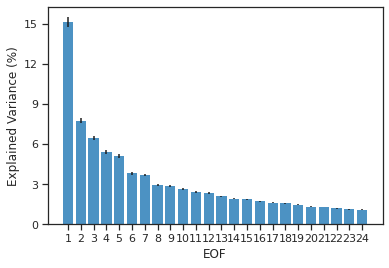

In [16]:
# set seaborn style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# create figure
fig, ax = plt.subplots(figsize=(6,4))

# plot data
xvals = np.arange(neofs) + 1
ax.bar(xvals, pctvar[0:neofs], yerr=err[0:neofs], 
       color='tab:blue', alpha=0.8)

# x-axis
ax.set_xlabel('EOF')
ax.set_xticks(xvals)

# y-axis
ax.set_ylabel('Explained Variance (%)')
yticks = np.arange(0,16,3)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks) 

# save fig
filepath = path_to_figs + 'exp_variance_' + fname_id + '.png'
plt.savefig(filepath, dpi=300)

# show
plt.show()

### Loadings

In [17]:
neofs = 19
loads = loadings(evals, evecs, neofs)

print(loads.shape)
print(np.round(loads,3))

(3339, 19)
[[ 0.413  0.153 -0.02  ...  0.015  0.052 -0.136]
 [ 0.47   0.245 -0.046 ... -0.007  0.094 -0.239]
 [ 0.248  0.238 -0.166 ... -0.022  0.164 -0.176]
 ...
 [ 0.08  -0.27   0.255 ... -0.007 -0.143 -0.18 ]
 [ 0.03  -0.38   0.126 ...  0.085  0.031 -0.136]
 [-0.15  -0.436  0.079 ...  0.048  0.138 -0.054]]


### Save EOFs

In [18]:
# Save eigenvalues, eigenvectors, and loadings

neofs = 4   # number of EOFs to save (evecs, loadings3)

outfile = path_to_out + 'eigenvalues_'+ fname_id + '.txt'
np.savetxt(outfile, evals, fmt='%.5f')

outfile = path_to_out + 'eigenvectors_'+ fname_id + '.txt'
np.savetxt(outfile, evecs[:,0:neofs], fmt='%.5f', delimiter=',')

outfile = path_to_out + 'loadings_'+ fname_id + '.txt'
np.savetxt(outfile, loads[:,0:neofs], fmt='%.4f', delimiter=',')


### PCs

In [19]:
# Calculate principal components (spatial modes)
neofs = 19
pcs = calc_pcs(Xs, evecs, neofs, mode=eofmode)

In [20]:
# Split pcs into separate arrays for each variable
ntim, nlat, nlon = var1.shape
npts = nlat*nlon
nvar = len(var_list)
# Reshape spatial dim back to 2D map
pcmodes = var_list
for i in np.arange(len(var_list)):
    tmp = pcs[:,i*npts:(i+1)*npts]
    pcmodes[i] = np.reshape(tmp, (neofs,nlat,nlon))

### Fig 3: Spatial Modes

In [23]:
# Panel Plot of Spatial Modes

# number of eofs to plot
neofs = 4

# Data for plotting extratropics
lons = merra.lon.data
lats = merra.lat.data
data = pcmodes[0][0:neofs,:,:]

print(np.nanmin(data), np.nanmax(data))

# Set up projection
# mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subtitles
eof_label = [ ]
var_label = [ ]
for k in range(neofs):
    eof_label.append("EOF{:1d}".format(k+1,))
    var_label.append("{:.2f}%".format(pctvar[k]))

-3.77951853524079 3.490470094199536


In [33]:
def draw_basemap(ax, extent=None, xticks=None, yticks=None, grid=False):
    """
    Creates and returns a background map on which to plot data. 
    
    Map features include continents and country borders.
    Option to set lat/lon tickmarks and draw gridlines.
    
    Parameters
    ----------
    ax : 
        plot Axes on which to draw the basemap
    
    extent : float
        Set map extent to [lonmin, lonmax, latmin, latmax] 
        Default: None (uses global extent)
        
    grid : bool
        Whether to draw grid lines. Default: False
        
    xticks : float
        array of xtick locations (longitude tick marks)
    
    yticks : float
        array of ytick locations (latitude tick marks)
        
    Returns
    -------
    ax :
        plot Axes with Basemap
    
    Notes
    -----
    - Grayscale colors can be set using 0 (black) to 1 (white)
    - Alpha sets transparency (0 is transparent, 1 is solid)
    
    """

    # Use map projection (CRS) of the given Axes
    mapcrs = ax.projection    
    
    ## Map Extent
    # If no extent is given, use global extent
    if extent is None:        
        ax.set_global()
        extent = [-180., 180., -90., 90.]
    # If extent is given, set map extent to lat/lon bounding box
    else:
        ax.set_extent(extent, crs=mapcrs)
    
    # Add map features (continents and country borders)
    ax.add_feature(cfeature.LAND, facecolor='0.9')      
    ax.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.8)
    ax.add_feature(cfeature.COASTLINE, edgecolor='0.4', linewidth=0.8)

    ## Tickmarks/Labels
    ## Add in meridian and parallels
    if mapcrs == ccrs.NorthPolarStereo():
        gl = ax.gridlines(crs=mapcrs, draw_labels=False,
                      linewidth=.5, color='black', alpha=0.5, linestyle='--')
    else:
        gl = ax.gridlines(crs=mapcrs, draw_labels=True,
                      linewidth=.5, color='black', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xlocator = mticker.FixedLocator(xticks)
        gl.ylocator = mticker.FixedLocator(yticks)
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 7, 'color': 'gray'}
        gl.ylabel_style = {'size': 7, 'color': 'gray'}
    
    ## Gridlines
    # Draw gridlines if requested
    if (grid == True):
        gl.xlines = True
        gl.ylines = True
    if (grid == False):
        gl.xlines = False
        gl.ylines = False
            

    # apply tick parameters    
    ax.tick_params(direction='out', 
                   labelsize=8.5, 
                   length=4, 
                   pad=2, 
                   color='black')
    
    return ax

## fix projection/gridlines for crs.NorthPolarStereo()

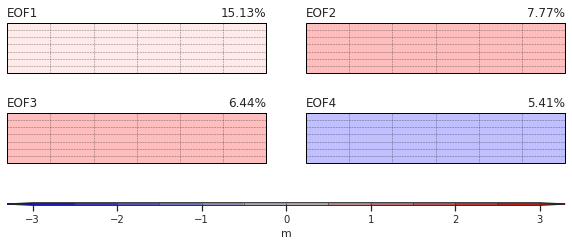

In [36]:
# Create figure
fig = plt.figure(figsize=(10,11))
filepath = path_to_figs + 'eofs_'+ fname_id + 'NPStest'+ '.png'
nrows = 2
ncols = 2
mapcrs = ccrs.PlateCarree()
mapcrs = ccrs.NorthPolarStereo()
# sns.set_style('ticks')

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 
                111, 
                axes_class=axes_class,
                nrows_ncols=(nrows, ncols), 
                axes_pad = 0.55,
                cbar_location='bottom', 
                cbar_mode='single',
                cbar_pad=0.0, 
                cbar_size='2.5%',
                label_mode='')

#newcmap = cmocean.tools.crop_by_percent(cmo.matter, 15, which='max', N=None)

# Loop for drawing each plot
for k, ax in enumerate(axgr):
#     ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], grid=True)
    # Add contour fill plot for extratropics
    clevs = np.arange(-3,3.5,.5)
    cf = ax.contourf(lons, lats, data[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
    
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.set_title(var_label[k], loc='right', fontsize=12)
    
# single colorbar
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('m', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Display figure
plt.savefig(filepath, dpi=200, bbox_inches='tight')
plt.show()

/home/nash/DATA/repositories/AR_types/figs/eofs_H700s-1801802090NPS.png


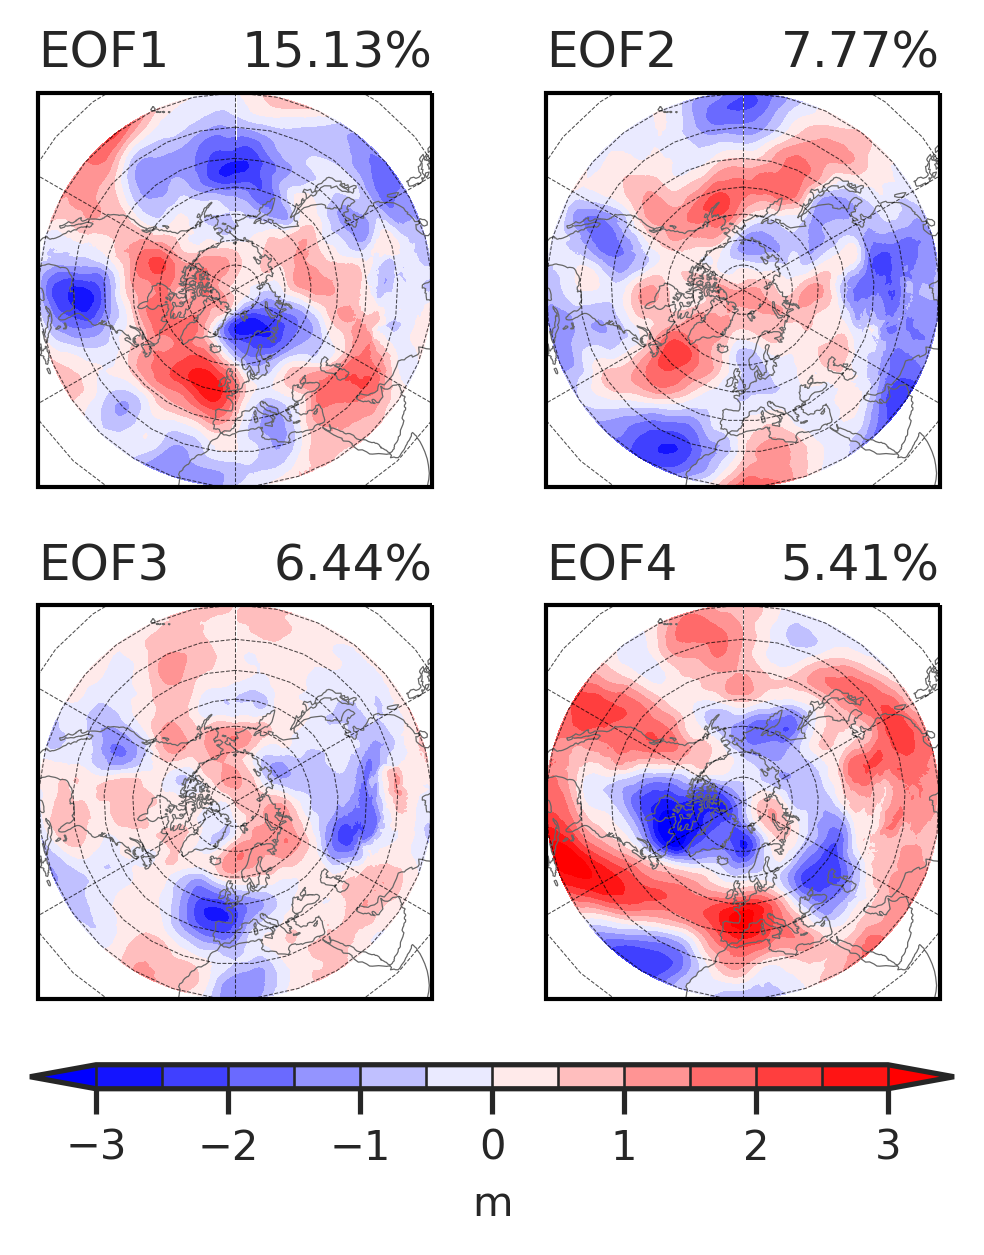

<Figure size 1200x1200 with 0 Axes>

In [27]:
fig = plt.figure(figsize=(4.0 ,4.0))
fig.dpi = 300
fname = path_to_figs + 'eofs_'+ fname_id + 'NPS'
fmt = 'png'

mapcrs = ccrs.NorthPolarStereo()

for k in np.arange(neofs):
    
    ax = plt.subplot(2, 2, k+1, projection=mapcrs)
#     ax.set_extent([lons.min(), lons.max(), lats.min(), 90.], crs=mapcrs)
    # Add contour fill plot for h500
    clevs = np.arange(-3,3.5,.5)
    cf = ax.contourf(lons, lats, data[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
    
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.set_title(var_label[k], loc='right', fontsize=12)
    
    ax.add_feature(cfeature.COASTLINE, edgecolor='0.4', linewidth=0.3)
#     ax.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.3)

    ## Add in meridian and parallels
    gl = ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--')

    
# # add colorbar [left, bottom, width, height]
ax2 = fig.add_axes([0.13, 0.05, 0.77, 0.02])
cbar = fig.colorbar(cf, cax=ax2, drawedges=True, 
                    orientation='horizontal', extendfrac='auto')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('m', fontsize=10)

plt.subplots_adjust(hspace=0.3)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))
# plt.show()